# Structure of semicrystalline polymer (R-BAPB) 

Investigation of microstructure of polyimide powder and films produced by SLS 3d-printing in scanning XRD experiment at ERSF

In [2]:
import h5py
import numpy as np
import scipy as scipy
from scipy import optimize
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
import time
import peakutils
%matplotlib inline

## Azimutal integration

In [18]:
# Loading file with already 'caked' scans
file_name = "H://LP/R-BAPB/print1416.h5"
file_num = '1416' # experiment id
data_inner_directory = "data/data" # path to data inside the archive
file = h5py.File(file_name, "r") # reading mode
all_scans = file[data_inner_directory] 
q_set = np.copy(file["data/q"]) # actual values for q and chi
chi_set = np.copy(file["data/chi"])
map_width = int(all_scans.shape[0]**0.5) 

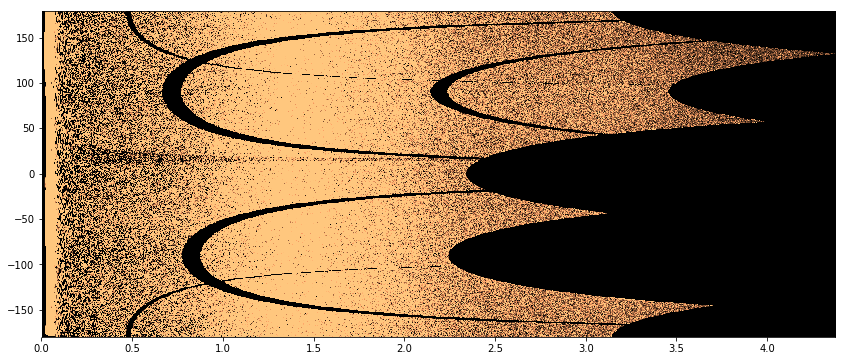

In [3]:
# Check up
fig = plt.figure(figsize=(15,6))
plt.imshow(all_scans[-100], 
           cmap = 'copper', 
           clim = (0,0.3), 
           extent=[q_set[0],q_set[-1],chi_set[0],chi_set[-1]], 
           interpolation = 'nearest',
           aspect = 0.005)

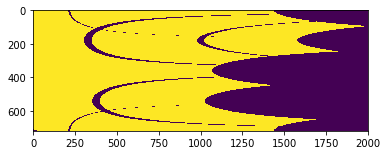

In [4]:
# Excluding gaps and beamstop
scan = all_scans[1]
mask = scan>=0
plt.imshow(mask)

In [5]:
np.save(file_num+'azim_mask', mask)

In [6]:
# Counting how many valid (q,chi) points there are for each point of profile
counts = np.zeros(all_scans.shape[2], dtype=np.float32)
for chi in range(all_scans.shape[1]):
    if chi not in range(315,360):
            for q in range(all_scans.shape[2]):
                if mask[chi,q]:
                    counts[q]+=1

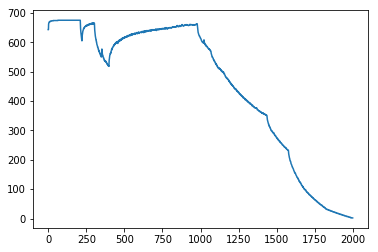

In [7]:
plt.plot(counts)

In [8]:
np.save(file_num+'azim_counts', counts)

In [9]:
# Creating a file to write integrated profiles in
new_file = h5py.File(file_num + "profiles.hdf5", "w")
dset = new_file.create_dataset("data", (all_scans.shape[0], all_scans.shape[2]), dtype= np.float32)

In [10]:
start_time = time.time() #time counter
counts = np.load(file_num+'azim_counts.npy')
mask = np.load(file_num+'azim_mask.npy')
for i in range(all_scans.shape[0]):
    profile = np.zeros(all_scans.shape[2], dtype=np.float32)
    current_scan = all_scans[i]*mask
    for chi in range(all_scans.shape[1]):
         if chi not in range(300,330):
                profile+=current_scan[chi]
    profile/=counts
    dset[i]=profile
    
    print(i," % seconds" % (time.time() - start_time)) # time display

        

0  0.16079235076904297econds
1  0.24074268341064453econds
2  0.4166910648345947econds
3  0.5536589622497559econds
4  0.6957199573516846econds
5  0.8158848285675049econds
6  0.9807815551757812econds
7  1.125396490097046econds
8  1.280562400817871econds
9  1.4893720149993896econds
10  1.6353411674499512econds
11  1.7525601387023926econds
12  1.92527437210083econds
13  2.0564277172088623econds
14  2.23097825050354econds
15  2.4049155712127686econds
16  2.584427833557129econds
17  2.7360026836395264econds
18  2.917889356613159econds
19  3.057300329208374econds
20  3.2233853340148926econds
21  3.342362642288208econds
22  3.540292978286743econds
23  3.7114040851593018econds
24  3.8884809017181396econds
25  4.022444248199463econds
26  4.205442428588867econds
27  4.379398345947266econds
28  4.539352178573608econds
29  4.659406900405884econds
30  4.852288007736206econds
31  5.024275302886963econds
32  5.149109363555908econds
33  5.342012405395508econds
34  5.579775094985962econds
35  5.73599696

286  50.5663857460022econds
287  50.6993522644043econds
288  50.843262910842896econds
289  50.987263441085815econds
290  51.115233182907104econds
291  51.276134967803955econds
292  51.446372747421265econds
293  51.5740008354187econds
294  51.69196605682373econds
295  51.85252833366394econds
296  52.01852321624756econds
297  52.14439010620117econds
298  52.29631304740906econds
299  52.456517457962036econds
300  52.57740330696106econds
301  52.724313259124756econds
302  52.89338684082031econds
303  53.00842213630676econds
304  53.260501861572266econds
305  53.4204466342926econds
306  53.53539991378784econds
307  53.71733021736145econds
308  53.866534948349econds
309  54.006547927856445econds
310  54.124293088912964econds
311  54.30286383628845econds
312  54.44845461845398econds
313  54.601022243499756econds
314  54.792919635772705econds
315  54.94637894630432econds
316  55.06877684593201econds
317  55.24568843841553econds
318  55.38533592224121econds
319  55.528942823410034econds
320  55

571  97.3309314250946econds
572  97.47091746330261econds
573  97.68078565597534econds
574  97.87855124473572econds
575  98.02239990234375econds
576  98.22763276100159econds
577  98.43922829627991econds
578  98.59733605384827econds
579  98.769371509552econds
580  98.99014568328857econds
581  99.14152407646179econds
582  99.34233927726746econds
583  99.54930019378662econds
584  99.70240497589111econds
585  99.87063121795654econds
586  100.06231546401978econds
587  100.23536157608032econds
588  100.36940741539001econds
589  100.55832242965698econds
590  100.72156476974487econds
591  100.85739421844482econds
592  101.03014850616455econds
593  101.27852964401245econds
594  101.45451736450195econds
595  101.66936779022217econds
596  101.83043336868286econds
597  101.99651193618774econds
598  102.24141502380371econds
599  102.38560628890991econds
600  102.58810877799988econds
601  102.77859282493591econds
602  102.91557598114014econds
603  103.10847759246826econds
604  103.28250980377197econd

849  144.20231199264526econds
850  144.32153511047363econds
851  144.50342440605164econds
852  144.6593780517578econds
853  144.80815267562866econds
854  144.9250419139862econds
855  145.09333395957947econds
856  145.2551667690277econds
857  145.39177775382996econds
858  145.55770564079285econds
859  145.70546579360962econds
860  145.83268022537231econds
861  145.99258136749268econds
862  146.1298792362213econds
863  146.3043727874756econds
864  146.42783403396606econds
865  146.62137365341187econds
866  146.76851892471313econds
867  146.91671180725098econds
868  147.0383849143982econds
869  147.30222487449646econds
870  147.46336388587952econds
871  147.58115673065186econds
872  147.7755832672119econds
873  147.94656944274902econds
874  148.09164762496948econds
875  148.2205891609192econds
876  148.4033772945404econds
877  148.56233525276184econds
878  148.6748538017273econds
879  148.83315587043762econds
880  148.95728969573975econds
881  149.1086881160736econds
882  149.246603727340

1123  186.48641753196716econds
1124  186.60268259048462econds
1125  186.7925636768341econds
1126  186.95978236198425econds
1127  187.08162546157837econds
1128  187.28135204315186econds
1129  187.49249076843262econds
1130  187.61199283599854econds
1131  187.79936480522156econds
1132  187.9533896446228econds
1133  188.06539249420166econds
1134  188.23528742790222econds
1135  188.38414883613586econds
1136  188.52632355690002econds
1137  188.65039777755737econds
1138  188.80737471580505econds
1139  188.96034979820251econds
1140  189.09476017951965econds
1141  189.25869727134705econds
1142  189.39181661605835econds
1143  189.5293984413147econds
1144  189.65582418441772econds
1145  189.8293960094452econds
1146  190.02187776565552econds
1147  190.20089292526245econds
1148  190.39012050628662econds
1149  190.52849102020264econds
1150  190.67104077339172econds
1151  190.79053020477295econds
1152  190.9503870010376econds
1153  191.1379587650299econds
1154  191.26124453544617econds
1155  191.4123

1394  229.03416538238525econds
1395  229.16345286369324econds
1396  229.3353452682495econds
1397  229.475732088089econds
1398  229.6086986064911econds
1399  229.73348784446716econds
1400  229.91438579559326econds
1401  230.05818057060242econds
1402  230.18333077430725econds
1403  230.34922981262207econds
1404  230.49282217025757econds
1405  230.64437699317932econds
1406  230.80052137374878econds
1407  230.976487159729econds
1408  231.11422753334045econds
1409  231.2774577140808econds
1410  231.3946509361267econds
1411  231.58343386650085econds
1412  231.7193112373352econds
1413  231.85406303405762econds
1414  231.97492289543152econds
1415  232.1708014011383econds
1416  232.38332438468933econds
1417  232.53399801254272econds
1418  232.73092365264893econds
1419  232.9068145751953econds
1420  233.06079697608948econds
1421  233.24168491363525econds
1422  233.3935832977295econds
1423  233.57453560829163econds
1424  233.6949121952057econds
1425  233.86037850379944econds
1426  234.02140426635

1663  275.41728949546814econds
1664  275.53574991226196econds
1665  275.74064540863037econds
1666  275.91574883461econds
1667  276.03175020217896econds
1668  276.22666120529175econds
1669  276.3793909549713econds
1670  276.5425717830658econds
1671  276.7154314517975econds
1672  276.9071502685547econds
1673  277.03927087783813econds
1674  277.19521927833557econds
1675  277.3462426662445econds
1676  277.4632649421692econds
1677  277.6836099624634econds
1678  277.8186368942261econds
1679  277.9645485877991econds
1680  278.1353847980499econds
1681  278.26738834381104econds
1682  278.42133927345276econds
1683  278.5502600669861econds
1684  278.74044466018677econds
1685  278.88125920295715econds
1686  279.0343008041382econds
1687  279.229220867157econds
1688  279.34849095344543econds
1689  279.5403685569763econds
1690  279.6875033378601econds
1691  279.798805475235econds
1692  279.98023104667664econds
1693  280.129061460495econds
1694  280.2816047668457econds
1695  280.39505314826965econds
1

1934  316.38276171684265econds
1935  316.5556926727295econds
1936  316.71080708503723econds
1937  316.87538623809814econds
1938  317.00570583343506econds
1939  317.1913719177246econds
1940  317.3413417339325econds
1941  317.4623727798462econds
1942  317.63760256767273econds
1943  317.7773439884186econds
1944  317.9119920730591econds
1945  318.0389702320099econds
1946  318.18488335609436econds
1947  318.3413908481598econds
1948  318.46138858795166econds
1949  318.6293158531189econds
1950  318.7987551689148econds
1951  318.9140956401825econds
1952  319.07937455177307econds
1953  319.23119735717773econds
1954  319.39085721969604econds
1955  319.5198402404785econds
1956  319.7007224559784econds
1957  319.83827662467957econds
1958  319.99664068222046econds
1959  320.1134729385376econds
1960  320.3043255805969econds
1961  320.4558017253876econds
1962  320.56840896606445econds
1963  320.732390165329econds
1964  320.8724024295807econds
1965  321.0073757171631econds
1966  321.1182539463043econd

2204  368.6759204864502econds
2205  368.8083574771881econds
2206  368.97463726997375econds
2207  369.1352152824402econds
2208  369.27140974998474econds
2209  369.423317193985econds
2210  369.59843492507935econds
2211  369.74145340919495econds
2212  369.902845621109econds
2213  370.04842352867126econds
2214  370.192574262619econds
2215  370.31468963623047econds
2216  370.4808156490326econds
2217  370.6435477733612econds
2218  370.79337310791016econds
2219  370.909827709198econds
2220  371.10974168777466econds
2221  371.2835009098053econds
2222  371.4195079803467econds
2223  371.6223864555359econds
2224  371.77939558029175econds
2225  371.910391330719econds
2226  372.0762891769409econds
2227  372.2062900066376econds
2228  372.3480615615845econds
2229  372.4671993255615econds
2230  372.68403482437134econds
2231  372.8166253566742econds
2232  372.9373252391815econds
2233  373.12513494491577econds
2234  373.3423385620117econds
2235  373.5055470466614econds
2236  373.6191487312317econds
2237

2476  411.9683885574341econds
2477  412.10891675949097econds
2478  412.2218482494354econds
2479  412.3769302368164econds
2480  412.5321247577667econds
2481  412.7469279766083econds
2482  412.94684767723083econds
2483  413.10583424568176econds
2484  413.22936487197876econds
2485  413.43133544921875econds
2486  413.60659098625183econds
2487  413.8104465007782econds
2488  414.01031398773193econds
2489  414.1642291545868econds
2490  414.33731412887573econds
2491  414.4564051628113econds
2492  414.673392534256econds
2493  414.8353488445282econds
2494  414.9513373374939econds
2495  415.1172640323639econds
2496  415.3011691570282econds
2497  415.43602776527405econds
2498  415.5991117954254econds
2499  415.7569317817688econds
2500  415.87580966949463econds
2501  416.0537679195404econds
2502  416.22696924209595econds
2503  416.3504230976105econds
2504  416.5360703468323econds
2505  416.70432567596436econds
2506  416.8441541194916econds
2507  416.96018075942993econds
2508  417.1501009464264econd

2747  455.9889466762543econds
2748  456.10999941825867econds
2749  456.3021922111511econds
2750  456.434862613678econds
2751  456.60755133628845econds
2752  456.77037143707275econds
2753  456.945024728775econds
2754  457.0765564441681econds
2755  457.22108912467957econds
2756  457.3914051055908econds
2757  457.5364122390747econds
2758  457.6560139656067econds
2759  457.83090591430664econds
2760  458.03256845474243econds
2761  458.185528755188econds
2762  458.37779235839844econds
2763  458.5505952835083econds
2764  458.67859959602356econds
2765  458.8915801048279econds
2766  459.06654691696167econds
2767  459.19761848449707econds
2768  459.3993740081787econds
2769  459.5906083583832econds
2770  459.7244117259979econds
2771  459.9003629684448econds
2772  460.0752623081207econds
2773  460.260014295578econds
2774  460.38178730010986econds
2775  460.53671312332153econds
2776  460.6866023540497econds
2777  460.8955512046814econds
2778  461.0198383331299econds
2779  461.2538278102875econds
27

3018  499.6668519973755econds
3019  499.78886222839355econds
3020  499.9663710594177econds
3021  500.13239073753357econds
3022  500.2918133735657econds
3023  500.41461062431335econds
3024  500.5981180667877econds
3025  500.7613778114319econds
3026  500.92965030670166econds
3027  501.04840898513794econds
3028  501.2073402404785econds
3029  501.36781787872314econds
3030  501.4848036766052econds
3031  501.6412892341614econds
3032  501.8173773288727econds
3033  501.9428298473358econds
3034  502.16000270843506econds
3035  502.3885359764099econds
3036  502.50306844711304econds
3037  502.6826798915863econds
3038  502.82741928100586econds
3039  502.9673810005188econds
3040  503.08134961128235econds
3041  503.2801640033722econds
3042  503.4197528362274econds
3043  503.53943252563477econds
3044  503.72001099586487econds
3045  503.8673210144043econds
3046  504.0092444419861econds
3047  504.1791708469391econds
3048  504.35705852508545econds
3049  504.47846126556396econds
3050  504.6483733654022eco

3294  546.4621911048889econds
3295  546.5826926231384econds
3296  546.7516045570374econds
3297  546.9543945789337econds
3298  547.0739548206329econds
3299  547.2528896331787econds
3300  547.3963196277618econds
3301  547.5418224334717econds
3302  547.657862663269econds
3303  547.8198819160461econds
3304  547.9608507156372econds
3305  548.1193161010742econds
3306  548.2543845176697econds
3307  548.4273815155029econds
3308  548.5714638233185econds
3309  548.7107424736023econds
3310  548.8240628242493econds
3311  549.0113866329193econds
3312  549.1502816677094econds
3313  549.3336224555969econds
3314  549.5403923988342econds
3315  549.7413744926453econds
3316  549.8805468082428econds
3317  549.9993839263916econds
3318  550.167328119278econds
3319  550.3777763843536econds
3320  550.4933288097382econds
3321  550.6578452587128econds
3322  550.790256023407econds
3323  550.9314835071564econds
3324  551.0954215526581econds
3325  551.2321312427521econds
3326  551.3760395050049econds
3327  551.525

3571  593.2128157615662econds
3572  593.3887076377869econds
3573  593.6193442344666econds
3574  593.8113598823547econds
3575  594.0233886241913econds
3576  594.2780516147614econds
3577  594.4375987052917econds
3578  594.6203198432922econds
3579  594.7937366962433econds
3580  594.9586825370789econds
3581  595.1427946090698econds
3582  595.3016307353973econds
3583  595.4486939907074econds
3584  595.6573731899261econds
3585  595.8395094871521econds
3586  595.9734108448029econds
3587  596.1813657283783econds
3588  596.3476176261902econds
3589  596.4814140796661econds
3590  596.6870465278625econds
3591  596.8754296302795econds
3592  597.0143597126007econds
3593  597.2572305202484econds
3594  597.447735786438econds
3595  597.6233360767365econds
3596  597.8512425422668econds
3597  598.0419456958771econds
3598  598.1896340847015econds
3599  598.3735730648041econds
3600  598.6656594276428econds
3601  598.8559679985046econds
3602  599.0367920398712econds
3603  599.2471058368683econds
3604  599.4

3848  643.2683007717133econds
3849  643.4454050064087econds
3850  643.654294013977econds
3851  643.8204746246338econds
3852  643.9547884464264econds
3853  644.1630611419678econds
3854  644.3441517353058econds
3855  644.4861357212067econds
3856  644.6990587711334econds
3857  644.901556968689econds
3858  645.0461235046387econds
3859  645.240406036377econds
3860  645.4013838768005econds
3861  645.5383188724518econds
3862  645.7883715629578econds
3863  645.9496712684631econds
3864  646.0933856964111econds
3865  646.335631608963econds
3866  646.5144345760345econds
3867  646.6462776660919econds
3868  646.8470931053162econds
3869  647.0203886032104econds
3870  647.1556024551392econds
3871  647.3623378276825econds
3872  647.5373504161835econds
3873  647.6956853866577econds
3874  647.9426481723785econds
3875  648.1050856113434econds
3876  648.2642769813538econds
3877  648.5399649143219econds
3878  648.7432007789612econds
3879  648.8829636573792econds
3880  649.0759227275848econds
3881  649.2733

4125  693.4035263061523econds
4126  693.5259773731232econds
4127  693.7385139465332econds
4128  693.8843722343445econds
4129  694.0172498226166econds
4130  694.2131559848785econds
4131  694.3751237392426econds
4132  694.5024042129517econds
4133  694.7023086547852econds
4134  694.8702528476715econds
4135  694.9973912239075econds
4136  695.2043609619141econds
4137  695.3928995132446econds
4138  695.5146346092224econds
4139  695.6955604553223econds
4140  695.9033806324005econds
4141  696.0214540958405econds
4142  696.1813790798187econds
4143  696.314239025116econds
4144  696.4692752361298econds
4145  696.6591548919678econds
4146  696.8370013237econds
4147  697.0005438327789econds
4148  697.1197235584259econds
4149  697.3033843040466econds
4150  697.4530158042908econds
4151  697.5924141407013econds
4152  697.7678787708282econds
4153  697.9673373699188econds
4154  698.1233167648315econds
4155  698.2393796443939econds
4156  698.416341304779econds
4157  698.5805294513702econds
4158  698.76239

4402  738.565408706665econds
4403  738.6814305782318econds
4404  738.8645689487457econds
4405  739.0142970085144econds
4406  739.1653828620911econds
4407  739.2834157943726econds
4408  739.4448933601379econds
4409  739.6421933174133econds
4410  739.7674422264099econds
4411  739.9253840446472econds
4412  740.0874538421631econds
4413  740.2084090709686econds
4414  740.3780572414398econds
4415  740.5522196292877econds
4416  740.6838076114655econds
4417  740.8807988166809econds
4418  741.0227687358856econds
4419  741.1437957286835econds
4420  741.3374495506287econds
4421  741.4913866519928econds
4422  741.6145806312561econds
4423  741.7843585014343econds
4424  741.9776363372803econds
4425  742.1533577442169econds
4426  742.3873193264008econds
4427  742.5523836612701econds
4428  742.6704595088959econds
4429  742.8463730812073econds
4430  743.0404622554779econds
4431  743.2094917297363econds
4432  743.3433873653412econds
4433  743.5402648448944econds
4434  743.698219537735econds
4435  743.81

4679  782.7453029155731econds
4680  782.8984351158142econds
4681  783.0658943653107econds
4682  783.2129843235016econds
4683  783.3780174255371econds
4684  783.5603611469269econds
4685  783.7143394947052econds
4686  783.8784413337708econds
4687  783.9984130859375econds
4688  784.1810834407806econds
4689  784.3503565788269econds
4690  784.5402834415436econds
4691  784.6883254051208econds
4692  784.8459477424622econds
4693  785.0080194473267econds
4694  785.127311706543econds
4695  785.287693977356econds
4696  785.4652373790741econds
4697  785.6004576683044econds
4698  785.784247636795econds
4699  785.9344456195831econds
4700  786.0535843372345econds
4701  786.2335679531097econds
4702  786.3823108673096econds
4703  786.5044829845428econds
4704  786.7004339694977econds
4705  786.8884027004242econds
4706  787.008483171463econds
4707  787.2033803462982econds
4708  787.3723585605621econds
4709  787.4914004802704econds
4710  787.6685590744019econds
4711  787.8098337650299econds
4712  787.9623

4956  836.4056084156036econds
4957  836.6026332378387econds
4958  836.8532247543335econds
4959  837.1297805309296econds
4960  837.4127960205078econds
4961  837.858011007309econds
4962  838.1079077720642econds
4963  838.3339033126831econds
4964  838.5236122608185econds
4965  838.8498287200928econds
4966  839.0668778419495econds
4967  839.3227484226227econds
4968  839.6163535118103econds
4969  839.8293979167938econds
4970  840.0762848854065econds
4971  840.310286283493econds
4972  840.6057441234589econds
4973  840.8872649669647econds
4974  841.1491537094116econds
4975  841.3774063587189econds
4976  841.6849794387817econds
4977  841.9433760643005econds
4978  842.1921122074127econds
4979  842.4646551609039econds
4980  842.7585003376007econds
4981  843.0253341197968econds
4982  843.3454165458679econds
4983  843.5563871860504econds
4984  843.8713400363922econds
4985  844.1281490325928econds
4986  844.3714005947113econds
4987  844.6673300266266econds
4988  844.9404437541962econds
4989  845.12

5231  919.5575726032257econds
5232  919.8525309562683econds
5233  920.1596744060516econds
5234  920.5216038227081econds
5235  920.7405817508698econds
5236  921.0614542961121econds
5237  921.3565335273743econds
5238  921.6732482910156econds
5239  921.9406428337097econds
5240  922.2326500415802econds
5241  922.5208127498627econds
5242  922.798079252243econds
5243  923.0788605213165econds
5244  923.3574135303497econds
5245  923.628485918045econds
5246  923.9544434547424econds
5247  924.2180263996124econds
5248  924.5574367046356econds
5249  924.8921740055084econds
5250  925.1401686668396econds
5251  925.3310496807098econds
5252  925.5578255653381econds
5253  925.9758298397064econds
5254  926.4519517421722econds
5255  926.8536093235016econds
5256  927.0646250247955econds
5257  927.3484501838684econds
5258  927.6442639827728econds
5259  929.5592975616455econds
5260  929.8132224082947econds
5261  930.3504981994629econds
5262  930.5291640758514econds
5263  930.8211121559143econds
5264  934.45

5507  1002.4828567504883econds
5508  1002.6574184894562econds
5509  1002.8737559318542econds
5510  1003.0453653335571econds
5511  1003.1775496006012econds
5512  1003.4024133682251econds
5513  1003.6106152534485econds
5514  1003.7887704372406econds
5515  1004.010931968689econds
5516  1004.1940331459045econds
5517  1004.3319654464722econds
5518  1004.5618939399719econds
5519  1005.1684560775757econds
5520  1005.3583769798279econds
5521  1005.7213835716248econds
5522  1005.9513986110687econds
5523  1006.1594738960266econds
5524  1006.4952795505524econds
5525  1006.7434680461884econds
5526  1006.9374094009399econds
5527  1007.2500109672546econds
5528  1007.5769855976105econds
5529  1007.9505980014801econds
5530  1008.2046253681183econds
5531  1008.5488760471344econds
5532  1008.8615522384644econds
5533  1009.0603756904602econds
5534  1009.2326281070709econds
5535  1009.3720257282257econds
5536  1009.6243860721588econds
5537  1009.8815891742706econds
5538  1010.15949177742econds
5539  1010.

5775  1068.1130990982056econds
5776  1068.3679659366608econds
5777  1068.7043163776398econds
5778  1069.036131620407econds
5779  1069.3179860115051econds
5780  1069.5568354129791econds
5781  1069.8038852214813econds
5782  1070.1516695022583econds
5783  1070.647575378418econds
5784  1070.9614386558533econds
5785  1071.332837343216econds
5786  1071.8919143676758econds
5787  1072.361100435257econds
5788  1072.569155216217econds
5789  1073.1340520381927econds
5790  1073.399043083191econds
5791  1073.9027471542358econds
5792  1074.1305334568024econds
5793  1074.359390258789econds
5794  1074.84645986557econds
5795  1075.1536891460419econds
5796  1075.5526459217072econds
5797  1075.7935907840729econds
5798  1076.0178039073944econds
5799  1076.3064115047455econds
5800  1076.6494770050049econds
5801  1076.8970658779144econds
5802  1077.1092817783356econds
5803  1077.4666814804077econds
5804  1077.8385977745056econds
5805  1078.3123075962067econds
5806  1078.7790191173553econds
5807  1079.043856

6043  1127.6214995384216econds
6044  1127.7365307807922econds
6045  1127.91042304039econds
6046  1128.0987076759338econds
6047  1128.2442028522491econds
6048  1128.3609817028046econds
6049  1128.555387020111econds
6050  1128.7013454437256econds
6051  1128.8174550533295econds
6052  1129.0098092556econds
6053  1129.1584956645966econds
6054  1129.2793462276459econds
6055  1129.4712481498718econds
6056  1129.636839389801econds
6057  1129.7719514369965econds
6058  1129.9708428382874econds
6059  1130.1530435085297econds
6060  1130.2762088775635econds
6061  1130.4315207004547econds
6062  1130.605857849121econds
6063  1130.725877046585econds
6064  1130.910859823227econds
6065  1131.0620439052582econds
6066  1131.2319383621216econds
6067  1131.4119551181793econds
6068  1131.5503883361816econds
6069  1131.7126438617706econds
6070  1131.8947112560272econds
6071  1132.029644727707econds
6072  1132.1389203071594econds
6073  1132.3344361782074econds
6074  1132.4974098205566econds
6075  1132.62141656

6311  1170.1433777809143econds
6312  1170.2713069915771econds
6313  1170.4461624622345econds
6314  1170.6301608085632econds
6315  1170.7578580379486econds
6316  1170.8713986873627econds
6317  1171.0483312606812econds
6318  1171.1927795410156econds
6319  1171.3105609416962econds
6320  1171.5053415298462econds
6321  1171.7039268016815econds
6322  1171.824259519577econds
6323  1172.0283670425415econds
6324  1172.1871273517609econds
6325  1172.3075575828552econds
6326  1172.4824533462524econds
6327  1172.6962473392487econds
6328  1172.810156583786econds
6329  1172.9820520877838econds
6330  1173.197913646698econds
6331  1173.3234014511108econds
6332  1173.5243513584137econds
6333  1173.6603767871857econds
6334  1173.7745623588562econds
6335  1173.9774124622345econds
6336  1174.1492993831635econds
6337  1174.2804043293econds
6338  1174.4503693580627econds
6339  1174.5853295326233econds
6340  1174.7283477783203econds
6341  1174.8603434562683econds
6342  1175.0462486743927econds
6343  1175.195

6579  1212.7987461090088econds
6580  1212.9174530506134econds
6581  1213.0693604946136econds
6582  1213.2365038394928econds
6583  1213.3514313697815econds
6584  1213.5053918361664econds
6585  1213.701800584793econds
6586  1213.8233480453491econds
6587  1213.978277206421econds
6588  1214.1156556606293econds
6589  1214.2611865997314econds
6590  1214.3952400684357econds
6591  1214.5612032413483econds
6592  1214.7223889827728econds
6593  1214.856306552887econds
6594  1215.0741715431213econds
6595  1215.2307760715485econds
6596  1215.3487544059753econds
6597  1215.5335054397583econds
6598  1215.7343616485596econds
6599  1215.8553960323334econds
6600  1216.0023515224457econds
6601  1216.1403832435608econds
6602  1216.257392168045econds
6603  1216.4138314723969econds
6604  1216.5610167980194econds
6605  1216.675811290741econds
6606  1216.8693554401398econds
6607  1217.0090596675873econds
6608  1217.1639630794525econds
6609  1217.3387560844421econds
6610  1217.4629600048065econds
6611  1217.63

6847  1255.046903848648econds
6848  1255.1739897727966econds
6849  1255.372867822647econds
6850  1255.5363738536835econds
6851  1255.6716928482056econds
6852  1255.812907218933econds
6853  1255.9381029605865econds
6854  1256.1425874233246econds
6855  1256.309557914734econds
6856  1256.4526543617249econds
6857  1256.5903754234314econds
6858  1256.7533934116364econds
6859  1256.9253826141357econds
6860  1257.0522985458374econds
6861  1257.2311894893646econds
6862  1257.3821768760681econds
6863  1257.5043983459473econds
6864  1257.6872894763947econds
6865  1257.8602793216705econds
6866  1258.0024123191833econds
6867  1258.1195795536041econds
6868  1258.298535823822econds
6869  1258.4521324634552econds
6870  1258.6084477901459econds
6871  1258.7345657348633econds
6872  1258.9292516708374econds
6873  1259.1063845157623econds
6874  1259.2693688869476econds
6875  1259.3925745487213econds
6876  1259.5623724460602econds
6877  1259.7040359973907econds
6878  1259.8483917713165econds
6879  1259.97

7116  1301.1686804294586econds
7117  1301.3169887065887econds
7118  1301.4981424808502econds
7119  1301.6506600379944econds
7120  1301.8342969417572econds
7121  1301.9832291603088econds
7122  1302.1381735801697econds
7123  1302.3083820343018econds
7124  1302.4313254356384econds
7125  1302.6954791545868econds
7126  1302.8673541545868econds
7127  1302.9913415908813econds
7128  1303.170390367508econds
7129  1303.3862240314484econds
7130  1303.5132386684418econds
7131  1303.76438498497econds
7132  1303.943512916565econds
7133  1304.0652425289154econds
7134  1304.244152545929econds
7135  1304.4056432247162econds
7136  1304.6163921356201econds
7137  1304.7587552070618econds
7138  1304.9019737243652econds
7139  1305.0687384605408econds
7140  1305.2539839744568econds
7141  1305.421691417694econds
7142  1305.5877213478088econds
7143  1305.7178106307983econds
7144  1305.8884444236755econds
7145  1306.1014606952667econds
7146  1306.225383758545econds
7147  1306.414707660675econds
7148  1306.58526

7385  1348.3820843696594econds
7386  1348.6620199680328econds
7387  1349.3003895282745econds
7388  1349.7343957424164econds
7389  1350.007329940796econds
7390  1350.5484409332275econds
7391  1350.8806416988373econds
7392  1351.3971514701843econds
7393  1351.6943798065186econds
7394  1351.9852199554443econds
7395  1352.2593293190002econds
7396  1352.5833356380463econds
7397  1352.8753650188446econds
7398  1353.2460405826569econds
7399  1353.492428779602econds
7400  1353.995033979416econds
7401  1354.35697555542econds
7402  1354.5421414375305econds
7403  1354.7537031173706econds
7404  1354.952661037445econds
7405  1355.1187620162964econds
7406  1356.9208316802979econds
7407  1357.238734960556econds
7408  1357.6364879608154econds
7409  1357.9173183441162econds
7410  1358.327719449997econds
7411  1358.6654450893402econds
7412  1359.0103657245636econds
7413  1359.3025493621826econds
7414  1359.550404548645econds
7415  1359.8185975551605econds
7416  1360.2215766906738econds
7417  1360.606410

7655  1426.2705166339874econds
7656  1426.428126335144econds
7657  1426.6703517436981econds
7658  1426.799535036087econds
7659  1426.9904594421387econds
7660  1427.142412662506econds
7661  1427.2734107971191econds
7662  1427.458346605301econds
7663  1427.6161000728607econds
7664  1427.7490627765656econds
7665  1428.0642359256744econds
7666  1428.2233834266663econds
7667  1428.3571047782898econds
7668  1428.5770301818848econds
7669  1428.7351689338684econds
7670  1428.8621428012848econds
7671  1429.094217300415econds
7672  1429.5303874015808econds
7673  1429.8492543697357econds
7674  1430.0880630016327econds
7675  1430.336576461792econds
7676  1430.490451335907econds
7677  1430.6745698451996econds
7678  1430.8324701786041econds
7679  1431.1383912563324econds
7680  1431.3320393562317econds
7681  1431.4990148544312econds
7682  1431.628033399582econds
7683  1431.8123631477356econds
7684  1431.9753849506378econds
7685  1432.1626660823822econds
7686  1432.3515524864197econds
7687  1432.52256

7924  1472.344378232956econds
7925  1472.4749960899353econds
7926  1472.6638791561127econds
7927  1472.8250741958618econds
7928  1472.9586281776428econds
7929  1473.173329114914econds
7930  1473.3372004032135econds
7931  1473.4632568359375econds
7932  1473.6581737995148econds
7933  1473.8223805427551econds
7934  1473.9474365711212econds
7935  1474.1503813266754econds
7936  1474.3153429031372econds
7937  1474.5024044513702econds
7938  1474.655378818512econds
7939  1474.7925839424133econds
7940  1474.922622203827econds
7941  1475.1313800811768econds
7942  1475.2726681232452econds
7943  1475.4685461521149econds
7944  1475.6931691169739econds
7945  1475.8440425395966econds
7946  1476.0089399814606econds
7947  1476.285348892212econds
7948  1476.4373762607574econds
7949  1476.6346881389618econds
7950  1476.8017547130585econds
7951  1476.9467182159424econds
7952  1477.1631181240082econds
7953  1477.3462252616882econds
7954  1477.4871444702148econds
7955  1477.8463554382324econds
7956  1478.04

8192  1515.4798984527588econds
8193  1515.6243560314178econds
8194  1515.80224609375econds
8195  1515.949379682541econds
8196  1516.094990491867econds
8197  1516.2144026756287econds
8198  1516.4162955284119econds
8199  1516.576266527176econds
8200  1516.7000634670258econds
8201  1516.902776002884econds
8202  1517.066874742508econds
8203  1517.1835932731628econds
8204  1517.3514890670776econds
8205  1517.5003695487976econds
8206  1517.6364147663116econds
8207  1517.756695985794econds
8208  1517.9310665130615econds
8209  1518.1001558303833econds
8210  1518.2155158519745econds
8211  1518.3718843460083econds
8212  1518.5230095386505econds
8213  1518.6730313301086econds
8214  1518.8299329280853econds
8215  1518.9686286449432econds
8216  1519.102799654007econds
8217  1519.2256574630737econds
8218  1519.413366317749econds
8219  1519.559344291687econds
8220  1519.6735529899597econds
8221  1519.8513133525848econds
8222  1520.006181716919econds
8223  1520.15713429451econds
8224  1520.28784537315

8461  1558.0854001045227econds
8462  1558.1983847618103econds
8463  1558.3829753398895econds
8464  1558.5294766426086econds
8465  1558.6795415878296econds
8466  1558.7997815608978econds
8467  1559.0135815143585econds
8468  1559.1433763504028econds
8469  1559.3483979701996econds
8470  1559.5245504379272econds
8471  1559.6999237537384econds
8472  1559.822214126587econds
8473  1560.0123977661133econds
8474  1560.1475858688354econds
8475  1560.296293258667econds
8476  1560.43327999115econds
8477  1560.5882284641266econds
8478  1560.7401850223541econds
8479  1560.8834125995636econds
8480  1561.011309146881econds
8481  1561.1961686611176econds
8482  1561.3421783447266econds
8483  1561.4575374126434econds
8484  1561.6274499893188econds
8485  1561.8166055679321econds
8486  1561.9289824962616econds
8487  1562.0929849147797econds
8488  1562.2447443008423econds
8489  1562.3994047641754econds
8490  1562.5307359695435econds
8491  1562.703682422638econds
8492  1562.8396735191345econds
8493  1562.969

8728  1599.7740819454193econds
8729  1599.9113943576813econds
8730  1600.1162855625153econds
8731  1600.299963235855econds
8732  1600.418353319168econds
8733  1600.5712594985962econds
8734  1600.7433836460114econds
8735  1600.8560004234314econds
8736  1600.999927520752econds
8737  1601.164797782898econds
8738  1601.28324842453econds
8739  1601.4321534633636econds
8740  1601.5630748271942econds
8741  1601.7189774513245econds
8742  1601.9625866413116econds
8743  1602.1002924442291econds
8744  1602.3972144126892econds
8745  1602.6268846988678econds
8746  1602.7928915023804econds
8747  1602.9070510864258econds
8748  1603.08997964859econds
8749  1603.2353868484497econds
8750  1603.3864221572876econds
8751  1603.501387834549econds
8752  1603.6992945671082econds
8753  1603.8753957748413econds
8754  1604.0003838539124econds
8755  1604.1893231868744econds
8756  1604.3375463485718econds
8757  1604.490970134735econds
8758  1604.6863760948181econds
8759  1604.8537948131561econds
8760  1605.0051727

8996  1643.8910961151123econds
8997  1644.0372903347015econds
8998  1644.2681803703308econds
8999  1644.4413862228394econds
9000  1644.5896966457367econds
9001  1644.7826535701752econds
9002  1644.9416551589966econds
9003  1645.0583074092865econds
9004  1645.2422075271606econds
9005  1645.3922584056854econds
9006  1645.556437253952econds
9007  1645.674803495407econds
9008  1645.8348097801208econds
9009  1646.0083236694336econds
9010  1646.1253352165222econds
9011  1646.309320449829econds
9012  1646.5103452205658econds
9013  1646.629872560501econds
9014  1646.7917892932892econds
9015  1646.931630373001econds
9016  1647.08438706398econds
9017  1647.218827009201econds
9018  1647.4222886562347econds
9019  1647.5723686218262econds
9020  1647.7128150463104econds
9021  1647.833475112915econds
9022  1647.991371870041econds
9023  1648.167468547821econds
9024  1648.2965865135193econds
9025  1648.449512720108econds
9026  1648.6052477359772econds
9027  1648.7359869480133econds
9028  1648.928932189

9264  1686.1340036392212econds
9265  1686.262395143509econds
9266  1686.4646627902985econds
9267  1686.6083827018738econds
9268  1686.7452857494354econds
9269  1686.9371693134308econds
9270  1687.101759672165econds
9271  1687.2527544498444econds
9272  1687.3747203350067econds
9273  1687.5446650981903econds
9274  1687.695458650589econds
9275  1687.834528684616econds
9276  1687.9957466125488econds
9277  1688.17236661911econds
9278  1688.2945094108582econds
9279  1688.4553699493408econds
9280  1688.5922989845276econds
9281  1688.7552888393402econds
9282  1688.8779711723328econds
9283  1689.0468835830688econds
9284  1689.1888613700867econds
9285  1689.3348994255066econds
9286  1689.4494087696075econds
9287  1689.6143143177032econds
9288  1689.7963938713074econds
9289  1689.9336392879486econds
9290  1690.1234471797943econds
9291  1690.3198056221008econds
9292  1690.4393908977509econds
9293  1690.5984330177307econds
9294  1690.7293055057526econds
9295  1690.873378276825econds
9296  1690.9868

9531  1728.6917991638184econds
9532  1728.8071808815002econds
9533  1728.9799246788025econds
9534  1729.1827630996704econds
9535  1729.3079249858856econds
9536  1729.4993569850922econds
9537  1729.6992769241333econds
9538  1729.81298494339econds
9539  1730.021277666092econds
9540  1730.199239730835econds
9541  1730.3219833374023econds
9542  1730.52388215065econds
9543  1730.695998430252econds
9544  1730.8162195682526econds
9545  1730.9821469783783econds
9546  1731.144065618515econds
9547  1731.2668147087097econds
9548  1731.4319410324097econds
9549  1731.609398841858econds
9550  1731.7547118663788econds
9551  1731.867413520813econds
9552  1732.158332824707econds
9553  1732.3989510536194econds
9554  1732.5204792022705econds
9555  1732.7543861865997econds
9556  1732.900295972824econds
9557  1733.7341494560242econds
9558  1734.1241941452026econds
9559  1734.5547437667847econds
9560  1734.9353935718536econds
9561  1735.199256181717econds
9562  1735.4492712020874econds
9563  1736.8344194889

9799  1783.396710395813econds
9800  1783.5614097118378econds
9801  1783.7143366336823econds
9802  1783.875287771225econds
9803  1784.0203762054443econds
9804  1784.2380850315094econds
9805  1784.3979618549347econds
9806  1784.5628578662872econds
9807  1784.7218253612518econds
9808  1784.959955215454econds
9809  1785.4616317749023econds
9810  1785.6818299293518econds
9811  1785.8367960453033econds
9812  1786.0046923160553econds
9813  1786.2251279354095econds
9814  1786.412516117096econds
9815  1786.5354402065277econds
9816  1786.7183856964111econds
9817  1786.9163253307343econds
9818  1787.087187051773econds
9819  1787.2392675876617econds
9820  1787.4510679244995econds
9821  1787.6141154766083econds
9822  1787.7603766918182econds
9823  1787.931313753128econds
9824  1788.0993473529816econds
9825  1788.2703132629395econds
9826  1788.4922623634338econds
9827  1788.6729056835175econds
9828  1788.8243939876556econds
9829  1788.999580860138econds
9830  1789.2225127220154econds
9831  1789.3695

10064  1831.1683275699615econds
10065  1831.3392951488495econds
10066  1831.6063067913055econds
10067  1831.8133616447449econds
10068  1831.9773526191711econds
10069  1832.174288034439econds
10070  1832.34823346138econds
10071  1832.5113995075226econds
10072  1832.7739217281342econds
10073  1832.9531123638153econds
10074  1833.1390640735626econds
10075  1833.3084359169006econds
10076  1833.4949889183044econds
10077  1833.7105417251587econds
10078  1833.8555076122284econds
10079  1834.0285246372223econds
10080  1834.2704639434814econds
10081  1834.425535440445econds
10082  1834.5834369659424econds
10083  1834.7803919315338econds
10084  1834.9184250831604econds
10085  1835.0727133750916econds
10086  1835.2546429634094econds
10087  1835.4169571399689econds
10088  1835.585245847702econds
10089  1835.754972934723econds
10090  1835.8769373893738econds
10091  1836.0588629245758econds
10092  1836.2281730175018econds
10093  1836.3919796943665econds
10094  1836.768568277359econds
10095  1836.962

10324  1877.3227326869965econds
10325  1877.4927597045898econds
10326  1877.7141435146332econds
10327  1877.898104429245econds
10328  1878.0828700065613econds
10329  1878.2723286151886econds
10330  1878.4333608150482econds
10331  1878.6042969226837econds
10332  1878.8053381443024econds
10333  1878.955323934555econds
10334  1879.1132700443268econds
10335  1879.2812159061432econds
10336  1879.4352304935455econds
10337  1879.6531431674957econds
10338  1879.8102838993073econds
10339  1879.991173505783econds
10340  1880.1713585853577econds
10341  1880.3505532741547econds
10342  1880.5023877620697econds
10343  1880.684327363968econds
10344  1880.8611121177673econds
10345  1881.0360491275787econds
10346  1881.1929948329926econds
10347  1881.3700766563416econds
10348  1881.5200502872467econds
10349  1881.711269378662econds
10350  1881.9311351776123econds
10351  1882.0730783939362econds
10352  1882.2340173721313econds
10353  1882.4171006679535econds
10354  1882.570004940033econds
10355  1882.76

10583  1923.7610833644867econds
10584  1923.8827862739563econds
10585  1924.09881067276econds
10586  1924.2766387462616econds
10587  1924.4149956703186econds
10588  1924.5979311466217econds
10589  1924.7980377674103econds
10590  1924.977368593216econds
10591  1925.1492886543274econds
10592  1925.3262031078339econds
10593  1925.5042896270752econds
10594  1925.7293660640717econds
10595  1925.8798019886017econds
10596  1926.017576932907econds
10597  1926.2563152313232econds
10598  1926.4404051303864econds
10599  1926.5824491977692econds
10600  1926.7750327587128econds
10601  1926.9843907356262econds
10602  1927.2222459316254econds
10603  1927.7589328289032econds
10604  1927.9705123901367econds
10605  1928.1464858055115econds
10606  1928.3374848365784econds
10607  1928.4982886314392econds
10608  1928.645272731781econds
10609  1928.8481991291046econds
10610  1929.0190937519073econds
10611  1929.1691477298737econds
10612  1929.3480803966522econds
10613  1929.5160975456238econds
10614  1929.6

10842  1971.3543303012848econds
10843  1971.4983253479004econds
10844  1971.6562414169312econds
10845  1971.8321597576141econds
10846  1971.982446193695econds
10847  1972.14457821846econds
10848  1972.3373718261719econds
10849  1972.4992439746857econds
10850  1972.664490222931econds
10851  1972.8795096874237econds
10852  1973.0566201210022econds
10853  1973.2653949260712econds
10854  1973.4274063110352econds
10855  1973.5733170509338econds
10856  1973.7565269470215econds
10857  1973.921448469162econds
10858  1974.0883569717407econds
10859  1974.2524495124817econds
10860  1974.43829703331econds
10861  1974.6143670082092econds
10862  1974.8206231594086econds
10863  1974.9998815059662econds
10864  1975.1690557003021econds
10865  1975.3971195220947econds
10866  1975.5569977760315econds
10867  1975.716377735138econds
10868  1975.886134147644econds
10869  1976.376003742218econds
10870  1976.5949819087982econds
10871  1976.8172116279602econds
10872  1977.0431661605835econds
10873  1977.254055

11102  2018.480500459671econds
11103  2018.6302616596222econds
11104  2018.7791712284088econds
11105  2018.9497663974762econds
11106  2019.0674171447754econds
11107  2019.2233400344849econds
11108  2019.4043791294098econds
11109  2019.5233750343323econds
11110  2019.6895833015442econds
11111  2019.8778450489044econds
11112  2020.0388133525848econds
11113  2020.285789489746econds
11114  2020.4362246990204econds
11115  2020.6401307582855econds
11116  2020.8091621398926econds
11117  2020.9301784038544econds
11118  2021.119212627411econds
11119  2021.2911577224731econds
11120  2021.4553878307343econds
11121  2021.6957886219025econds
11122  2021.8812808990479econds
11123  2022.0636563301086econds
11124  2022.3730084896088econds
11125  2022.529606103897econds
11126  2022.6885168552399econds
11127  2022.8593876361847econds
11128  2023.0323038101196econds
11129  2023.2175951004028econds
11130  2023.382066488266econds
11131  2023.562382698059econds
11132  2023.7502989768982econds
11133  2023.90

11362  2067.271731853485econds
11363  2067.4278693199158econds
11364  2067.593947172165econds
11365  2067.7609610557556econds
11366  2067.919904232025econds
11367  2068.205109357834econds
11368  2068.3651049137115econds
11369  2068.5996520519257econds
11370  2068.7418031692505econds
11371  2068.9179730415344econds
11372  2069.0866260528564econds
11373  2069.311368703842econds
11374  2069.4762976169586econds
11375  2069.705821990967econds
11376  2069.8347387313843econds
11377  2070.0875704288483econds
11378  2070.2316133975983econds
11379  2070.468756914139econds
11380  2070.625447034836econds
11381  2070.802377462387econds
11382  2070.9463579654694econds
11383  2071.1413345336914econds
11384  2071.280398607254econds
11385  2071.5223500728607econds
11386  2071.6753079891205econds
11387  2071.87824344635econds
11388  2072.0787703990936econds
11389  2072.2228043079376econds
11390  2072.3753848075867econds
11391  2072.535570383072econds
11392  2072.7127306461334econds
11393  2072.958104372

11622  2114.180591583252econds
11623  2114.3637804985046econds
11624  2114.550755739212econds
11625  2114.782501935959econds
11626  2114.92644405365econds
11627  2115.087342739105econds
11628  2115.2639956474304econds
11629  2115.3759655952454econds
11630  2115.5442039966583econds
11631  2115.682113647461econds
11632  2115.838371038437econds
11633  2116.0664913654327econds
11634  2116.2163710594177econds
11635  2116.368268728256econds
11636  2116.537248849869econds
11637  2116.7042269706726econds
11638  2116.8620488643646econds
11639  2117.0980772972107econds
11640  2117.270055294037econds
11641  2117.440202474594econds
11642  2117.6273856163025econds
11643  2117.8918633461econds
11644  2118.075348854065econds
11645  2118.288270711899econds
11646  2118.464834213257econds
11647  2118.6147286891937econds
11648  2118.816809654236econds
11649  2119.022868156433econds
11650  2119.1729464530945econds
11651  2119.3397858142853econds
11652  2119.632394552231econds
11653  2119.8114006519318econ

11885  2162.431437730789econds
11886  2162.5925254821777econds
11887  2162.758446455002econds
11888  2162.952546596527econds
11889  2163.131456375122econds
11890  2163.289388179779econds
11891  2163.4963462352753econds
11892  2163.647442817688econds
11893  2163.822381258011econds
11894  2164.0403382778168econds
11895  2164.186576604843econds
11896  2164.4384820461273econds
11897  2164.8848752975464econds
11898  2165.095048427582econds
11899  2165.3370156288147econds
11900  2165.6284041404724econds
11901  2165.8434779644012econds
11902  2166.2122333049774econds
11903  2166.4205005168915econds
11904  2166.7044534683228econds
11905  2166.924330472946econds
11906  2167.177250146866econds
11907  2167.3864986896515econds
11908  2167.584364414215econds
11909  2167.833305835724econds
11910  2168.1282653808594econds
11911  2168.3822355270386econds
11912  2168.672112941742econds
11913  2169.065756559372econds
11914  2169.264377117157econds
11915  2169.525223970413econds
11916  2169.797441959381e

12146  2213.5962109565735econds
12147  2213.7533740997314econds
12148  2213.9282896518707econds
12149  2214.100843667984econds
12150  2214.252027273178econds
12151  2214.4983644485474econds
12152  2214.648325920105econds
12153  2214.8523619174957econds
12154  2215.0153040885925econds
12155  2215.158499479294econds
12156  2215.4086878299713econds
12157  2215.5712890625econds
12158  2215.7281925678253econds
12159  2215.929183959961econds
12160  2216.0841755867004econds
12161  2216.252422809601econds
12162  2216.417361021042econds
12163  2216.6339004039764econds
12164  2216.7794167995453econds
12165  2216.9353787899017econds
12166  2217.118357896805econds
12167  2217.280258655548econds
12168  2217.4683039188385econds
12169  2217.647622346878econds
12170  2217.812520980835econds
12171  2218.0020904541016econds
12172  2218.217400074005econds
12173  2218.980324745178econds
12174  2219.1740193367004econds
12175  2219.3244800567627econds
12176  2219.526352405548econds
12177  2219.7123708724976

12408  2263.815458059311econds
12409  2263.9974250793457econds
12410  2264.144450902939econds
12411  2264.350486755371econds
12412  2264.517926931381econds
12413  2264.6625366210938econds
12414  2264.916394472122econds
12415  2265.0693867206573econds
12416  2265.3228511810303econds
12417  2265.5084109306335econds
12418  2265.6793055534363econds
12419  2265.902357339859econds
12420  2266.0463194847107econds
12421  2266.2433636188507econds
12422  2266.4283640384674econds
12423  2266.5782327651978econds
12424  2266.786657333374econds
12425  2266.9916174411774econds
12426  2267.16831946373econds
12427  2267.329046726227econds
12428  2267.4753448963165econds
12429  2267.598596572876econds
12430  2267.770511865616econds
12431  2267.9918632507324econds
12432  2268.1398644447327econds
12433  2268.2988681793213econds
12434  2268.4561870098114econds
12435  2268.6869552135468econds
12436  2268.888906955719econds
12437  2269.065289735794econds
12438  2269.2752735614777econds
12439  2269.4373416900

12669  2311.4598138332367econds
12670  2311.637702703476econds
12671  2311.806777715683econds
12672  2311.9867560863495econds
12673  2312.1484558582306econds
12674  2312.316370487213econds
12675  2312.5285773277283econds
12676  2312.6873831748962econds
12677  2312.8391246795654econds
12678  2313.0611617565155econds
12679  2313.2282366752625econds
12680  2313.4042546749115econds
12681  2313.592250585556econds
12682  2313.80135178566econds
12683  2314.005297899246econds
12684  2314.153330564499econds
12685  2314.3175127506256econds
12686  2314.512133836746econds
12687  2314.6613371372223econds
12688  2314.839545726776econds
12689  2315.0279669761658econds
12690  2315.1884772777557econds
12691  2315.457353591919econds
12692  2315.74440407753econds
12693  2315.96746969223econds
12694  2316.1893787384033econds
12695  2316.4453003406525econds
12696  2316.812390565872econds
12697  2317.01442360878econds
12698  2317.288516521454econds
12699  2317.4793059825897econds
12700  2317.632895231247eco

12930  2359.563098669052econds
12931  2359.7563667297363econds
12932  2359.937847852707econds
12933  2360.1204018592834econds
12934  2360.2673416137695econds
12935  2360.4632675647736econds
12936  2360.667724132538econds
12937  2360.838421344757econds
12938  2361.0703451633453econds
12939  2361.290302991867econds
12940  2361.437383890152econds
12941  2361.6564993858337econds
12942  2361.860348701477econds
12943  2362.004466533661econds
12944  2362.191375732422econds
12945  2362.3910887241364econds
12946  2362.5462489128113econds
12947  2362.715512752533econds
12948  2362.916293144226econds
12949  2363.070386171341econds
12950  2363.2073159217834econds
12951  2363.427185535431econds
12952  2363.5724308490753econds
12953  2363.8123755455017econds
12954  2363.957419395447econds
12955  2364.127823114395econds
12956  2364.3065097332econds
12957  2364.5065035820007econds
12958  2364.6954214572906econds
12959  2364.8884279727936econds
12960  2365.0453963279724econds
12961  2365.220307826996ec

13192  2407.5096442699432econds
13193  2407.666988134384econds
13194  2407.826889038086econds
13195  2407.982876062393econds
13196  2408.119790792465econds
13197  2408.3023583889008econds
13198  2408.4461209774017econds
13199  2408.6556346416473econds
13200  2408.801381111145econds
13201  2408.949389219284econds
13202  2409.14857673645econds
13203  2409.3106429576874econds
13204  2409.480383872986econds
13205  2409.765313386917econds
13206  2409.9224588871econds
13207  2410.103429555893econds
13208  2410.313405752182econds
13209  2410.480237722397econds
13210  2410.696823120117econds
13211  2410.894247531891econds
13212  2411.044298887253econds
13213  2411.2521483898163econds
13214  2411.4371950626373econds
13215  2411.581509590149econds
13216  2411.7778010368347econds
13217  2411.9806792736053econds
13218  2412.1559958457947econds
13219  2412.396551132202econds
13220  2412.5584259033203econds
13221  2412.7503802776337econds
13222  2412.902488708496econds
13223  2413.0674591064453econd

13453  2455.0670540332794econds
13454  2455.2171127796173econds
13455  2455.3740305900574econds
13456  2455.540924310684econds
13457  2455.695513486862econds
13458  2455.9913017749786econds
13459  2456.1533336639404econds
13460  2456.320232629776econds
13461  2456.4993226528168econds
13462  2456.6301832199097econds
13463  2456.823066473007econds
13464  2457.0954744815826econds
13465  2457.245382785797econds
13466  2457.40251994133econds
13467  2457.592474460602econds
13468  2457.7442886829376econds
13469  2457.9283759593964econds
13470  2458.078500032425econds
13471  2458.255306005478econds
13472  2458.4361872673035econds
13473  2458.6714005470276econds
13474  2458.819370031357econds
13475  2459.035999059677econds
13476  2459.202944755554econds
13477  2459.3428518772125econds
13478  2459.503392934799econds
13479  2459.692365169525econds
13480  2459.880594968796econds
13481  2460.0464367866516econds
13482  2460.260354757309econds
13483  2460.4602403640747econds
13484  2460.6132237911224

13714  2502.1991758346558econds
13715  2502.3434262275696econds
13716  2502.517335176468econds
13717  2502.718531847econds
13718  2502.8710327148438econds
13719  2503.07235622406econds
13720  2503.237622976303econds
13721  2503.4035127162933econds
13722  2503.605527162552econds
13723  2503.7623629570007econds
13724  2503.982996940613econds
13725  2504.1426091194153econds
13726  2504.3213698863983econds
13727  2504.5154254436493econds
13728  2504.674408197403econds
13729  2504.962165117264econds
13730  2505.1154918670654econds
13731  2505.3291997909546econds
13732  2505.473164796829econds
13733  2505.658981323242econds
13734  2505.8261365890503econds
13735  2505.9549889564514econds
13736  2506.13414311409econds
13737  2506.3362765312195econds
13738  2506.5157759189606econds
13739  2506.66131067276econds
13740  2506.8572232723236econds
13741  2507.0171897411346econds
13742  2507.173184156418econds
13743  2507.3643686771393econds
13744  2507.577577114105econds
13745  2507.7480795383453eco

13977  2549.8321533203125econds
13978  2549.9551904201508econds
13979  2550.134098291397econds
13980  2550.365175962448econds
13981  2550.508595943451econds
13982  2550.69664645195econds
13983  2550.8726184368134econds
13984  2551.055443048477econds
13985  2551.2399389743805econds
13986  2551.421891927719econds
13987  2551.573388338089econds
13988  2551.797316789627econds
13989  2551.965655565262econds
13990  2552.1153910160065econds
13991  2552.290313720703econds
13992  2552.5046603679657econds
13993  2552.674674510956econds
13994  2552.892409801483econds
13995  2553.0565910339355econds
13996  2553.2557802200317econds
13997  2553.416580915451econds
13998  2553.5775184631348econds
13999  2553.7624051570892econds
14000  2554.110536336899econds
14001  2554.3582944869995econds
14002  2554.519955635071econds
14003  2554.684873342514econds
14004  2554.8882570266724econds
14005  2555.0316054821014econds
14006  2555.2365012168884econds
14007  2555.418519973755econds
14008  2555.5667164325714e

14238  2598.9590690135956econds
14239  2599.104348897934econds
14240  2599.2882504463196econds
14241  2599.481005191803econds
14242  2599.6392633914948econds
14243  2599.810880422592econds
14244  2599.9592657089233econds
14245  2600.1136701107025econds
14246  2600.2925083637238econds
14247  2600.4387378692627econds
14248  2600.613301753998econds
14249  2600.7934675216675econds
14250  2601.0194396972656econds
14251  2601.169417858124econds
14252  2601.333548784256econds
14253  2601.539167165756econds
14254  2601.6629450321198econds
14255  2601.828381538391econds
14256  2601.98494720459econds
14257  2602.1685910224915econds
14258  2602.32039642334econds
14259  2602.510298728943econds
14260  2602.6793854236603econds
14261  2602.8509635925293econds
14262  2603.056439638138econds
14263  2603.232209444046econds
14264  2603.396198272705econds
14265  2603.5939021110535econds
14266  2603.797899246216econds
14267  2603.983371734619econds
14268  2604.197357416153econds
14269  2604.3666355609894ec

14501  2646.5214927196503econds
14502  2646.645483016968econds
14503  2646.837385416031econds
14504  2647.0283496379852econds
14505  2647.22909116745econds
14506  2647.4630043506622econds
14507  2647.607734680176econds
14508  2647.7646884918213econds
14509  2647.9699568748474econds
14510  2648.1190423965454econds
14511  2648.28697013855econds
14512  2648.4849820137024econds
14513  2648.653744697571econds
14514  2648.8286650180817econds
14515  2648.994889974594econds
14516  2649.1384012699127econds
14517  2649.3230485916138econds
14518  2649.4894416332245econds
14519  2649.644436120987econds
14520  2649.8343646526337econds
14521  2650.0312552452087econds
14522  2650.1915225982666econds
14523  2650.405432701111econds
14524  2650.601934194565econds
14525  2650.7893846035004econds
14526  2650.9593362808228econds
14527  2651.120360136032econds
14528  2651.279355287552econds
14529  2651.493177652359econds
14530  2651.6653621196747econds
14531  2651.8161284923553econds
14532  2652.02335000038

In [6]:
#new_file.close()
file.close()

In [12]:
#Check is everything went fine
file = h5py.File(file_num+"profiles.hdf5", "r")
data = file['data']

array([0.        , 0.00465262, 0.20425661, ..., 0.11791433, 0.02608842,
       0.        ], dtype=float32)

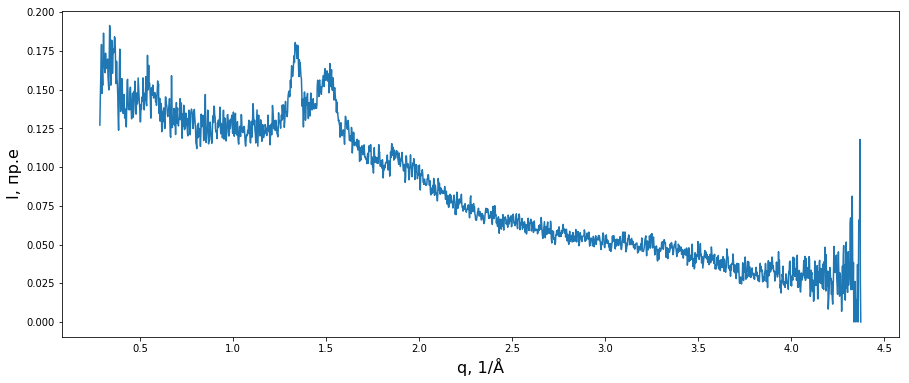

In [65]:
#Displaying profiles

profile = data[1197]
fig = plt.figure(figsize=(15,6))
plt.plot(q_set[130:],profile[130:])
plt.ylabel("I, пр.е", fontsize = 16)
plt.xlabel("q, 1/\u212B", fontsize = 16)
#plt.savefig(file_num+'profile.pdf')
profile

In [14]:
file.close()

## Invariant calculation

Theory:

$Inv = \int_0^{\infty}I(q)q^2dq = Cr + Am$

$CI = \frac{Cr}{Inv}$

In [342]:
file_num = '1434'
file = h5py.File(file_num+"profiles.hdf5", "r")
data = file['data']
q_set = np.load('q.npy')
map_width = int(data.shape[0]**0.5)

In [343]:
inv_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

In [344]:
q_set = q_set[100:]
base = np.load('base.npy')

In [347]:


for i in range(data.shape[0]):
    profile = data[i]
    x = int(i%map_width)
    y = int(i//map_width)   
    
    
    profile = profile[100:]
    
    inv_map_data[y, x]=scipy.integrate.trapz((profile-base)*q_set*q_set, q_set)-I
    

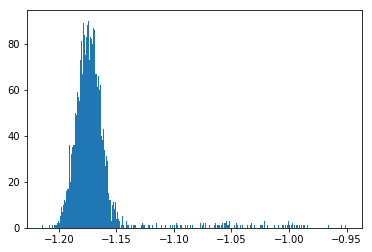

0.026452532
-1.2145735
-0.95013905
-1.1696002


In [338]:
flat = inv_map_data.flatten()
plt.hist(flat, bins = 300)
plt.show()
print(np.std(flat))
print(np.amin(flat))
print(np.amax(flat))
print(np.mean(flat))

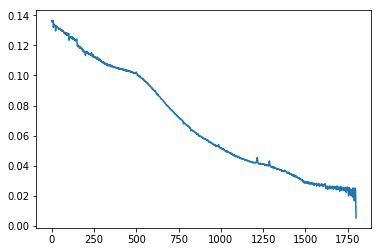

In [345]:
base=np.zeros(2000, dtype=np.float32) 
for i in range(500):
    base+=data[i]
    
base/=500
base = base[100:]
plt.plot(base[100:])
I = scipy.integrate.trapz(base*q_set*q_set, q_set)

In [346]:
np.save('base',base)

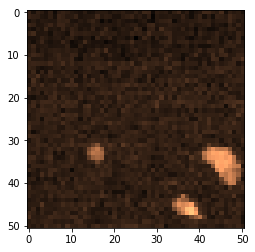

In [348]:
plt.imshow(inv_map_data, cmap = 'copper')
np.save(file_num+'inv_map', inv_map_data)

In [340]:
file.close()

## Mapping

In [ ]:
#Initial global parameters
map_width = 1 #default value
min_ROI_q = 570 # region of interest for q, data point indices
max_ROI_q = 650
min_ROI_chi = 0 # region of interest for angle chi, data point indices
max_ROI_chi = 720 


all_scans.shape

In [ ]:
q_set = file["data/q"]
q_set = np.asarray(q_set)

In [ ]:
q_set = 360*np.arcsin(q_set*0.8349/(4*np.pi))/np.pi

In [ ]:
file.close()

In [ ]:
dset = file['data']

In [ ]:
list(dset.keys())

In [ ]:
np.save('q_set',q_set)
np.save('chi_set', chi_set)
np.save('test_scan', all_scans[600])

In [ ]:
q_set[230]

In [ ]:
scan = all_scans[14640]
fig, ax = plt.subplots(figsize=(6,6))
plt.ylabel("Угол \u03C7, град.")
plt.xlabel("q, 1/\u212B")
ax.imshow(scan[:360,450:850], cmap='copper', interpolation='none', extent=[q_set[450],q_set[850],chi_set[0],chi_set[360]], clim = (0,1.5), aspect = 0.005)
#plt.savefig('azim-amo.pdf')11

In [ ]:
plt.hist(scan[1], bins = 300)
plt.show()

In [ ]:
scan = np.load('scan_sum1434.npy')

In [ ]:
for row in scan:
    row[row<0]= np.nan
    
print (scan[10])

In [ ]:
360/np.pi*np.arcsin(0.08/np.pi)

In [ ]:
profile = scan[100]+scan[101]+scan[102]
    
plt.plot(q_set,profile)

In [ ]:

min_ROI_q = 230 # region of interest for q, data point indices
max_ROI_q = 1375

profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
j_counter = 0
for j in range (min_ROI_chi,max_ROI_chi):
    profile = np.nan_to_num(scan[j])           
    profile_sum += profile
    j_counter+=1
#profile_sum/=j_counter


x = q_set[min_ROI_q:max_ROI_q]
y = profile_sum[min_ROI_q:max_ROI_q]

plt.figure(figsize=(10,6))
plt.plot(x,y)
profile_sum

In [ ]:
#local normalisation
local_mu = np.nanmean(profile_sum[min_ROI_q-100:max_ROI_q+100])
local_sigma = np.nanstd(profile_sum[min_ROI_q-100:max_ROI_q+100])

local_profile = profile_sum[min_ROI_q-100:max_ROI_q+100]

for cell in local_profile:
    cell = (cell - local_mu)/local_sigma

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(q_set[min_ROI_q:max_ROI_q],local_profile[100:-100])


In [ ]:
local_profile[100:-100] == profile_sum[min_ROI_q:max_ROI_q]

In [ ]:
### without normalization
new_scan = all_scans[1000]
#for i in range(100):
 #   new_scan+=all_scans[i]


min_ROI_q =  570 # region of interest for q, data point indices
max_ROI_q = 650

new_profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
j_counter = 0
for j in range (min_ROI_chi,max_ROI_chi):
    if j not in range(330,360): #exclude beamstop
        profile = new_scan[j]    
        if (-10 not  in profile[min_ROI_q:max_ROI_q]):
            new_profile_sum += profile
            j_counter+=1
#new_profile_sum/=j_counter


x = q_set[min_ROI_q:max_ROI_q]
y = new_profile_sum[min_ROI_q:max_ROI_q]

plt.figure(figsize=(11,6))
plt.ylabel("I, пр.е")
plt.xlabel("q, 1/\u212B")
plt.plot(x,y, 'bo')

j_counter
#plt.savefig("waxs_profile.pdf")

In [ ]:
new_profile_sum-=550

In [ ]:
x = q_set[min_ROI_q:max_ROI_q]
y = new_profile_sum[min_ROI_q:max_ROI_q]

plt.figure(figsize=(11,6))
plt.ylabel("I, пр.е")
plt.xlabel("q, 1/\u212B")
plt.plot(x,y, 'bo')

In [ ]:
np.save('profile_gauss1', new_profile_sum[min_ROI_q:max_ROI_q])
np.save('q_gauss1', q_set[min_ROI_q:max_ROI_q])

In [ ]:
np.save('profile', new_profile_sum[min_ROI_q:max_ROI_q])

In [ ]:
#Mapping by simply integrating in ROI_q


#baseline = np.load('1434profile.npy')
start_time = time.time() #time counter
stn_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        j_counter = 0
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
                profile_sum += profile
                j_counter+=1
        profile_sum/=j_counter
        
        
        y_wide = scipy.signal.savgol_filter(profile_sum[min_ROI_q-70:max_ROI_q+70], window_length= 25, polyorder= 3, deriv=0, delta=0.1, axis=-1, mode='interp', cval=0.0)
        #base = peakutils.baseline(profile_sum[min_ROI_q-70:max_ROI_q+70], deg=5)
        #y_wide= profile_sum[min_ROI_q-70:max_ROI_q+70]-base
        

        x_set = q_set[min_ROI_q:max_ROI_q]
        y_set = y_wide[70:-70]

        #popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, p0=[1.3,0.05,0.5,0.1], method = 'dogbox')
        I = scipy.integrate.trapz(x = x_set, y = y_set)
        print(I)
        
        
        x = int(i%map_width)
        y = int(i//map_width)
        
        stn_map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

#saving map data

np.save(file_num + 'trapz_map_data', stn_map_data)

In [ ]:
#Summing all  scans of the experiment


scan_sum = np.zeros((all_scans.shape[1],all_scans.shape[2]), dtype = np.float32)
start_time = time.time()
for scan in all_scans:
    scan_sum+=scan
    print("--- %s seconds ---" % (time.time() - start_time))
    
scan_sum/=all_scans.shape[0] #normalizing

#saving

np.save('scan_sum' + file_num, scan_sum)

In [ ]:
#Assembling a normilized profile from different parts of a scan (because yeah I don't have mask files)

#scan_sum = np.load('scan_sum' + file_num + '.npy', )

#TODO - зашкал при i=6 - почему???
#Сшивка между срезами - чем больше N, тем меньше разница

M = all_scans.shape[2] #number of points in profile
N=3 #number of slices
halo_profile = np.zeros(M, dtype=np.float32)
for i in range(N):  
    
    min_slice = int(M*i/N)
    max_slice = int(M*(i+1)/N)
    counter = 0 
    print(i, min_slice, max_slice)
    local_sum = np.zeros(M, dtype=np.float32)
    
    for j in range(min_ROI_chi, max_ROI_chi):
        profile = scan_sum[j]
        if not any(x<=0 for x in profile[min_slice:max_slice]):
            local_sum[min_slice:max_slice]+=profile[min_slice:max_slice]        
            counter +=1
                
    print(counter)
    halo_profile[min_slice:max_slice] += (local_sum[min_slice:max_slice]/counter) 


fig = plt.figure(figsize=(15,10))
plt.plot(q_set,halo_profile, label = 'halo profile')


#Setting scale 
ax = fig.add_subplot(2, 1, 1)
ax.loglog(q_set,halo_profile, label = 'loglog halo profile')

#ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend()

#saving
np.save('halo_profile' + file_num, scan_sum)
np.savetxt('halo_profile' + file_num + '.txt', halo_profile)
np.savetxt('q_set' + file_num + '.txt', q_set)


In [ ]:
#Loading corrected halo profile
halo_baseline = np.loadtxt('halo_baseline' + file_num +'.txt')
print(halo_baseline)
#Integrating, saving

#1434 halo slice: 45-1998
halo_min = 1
halo_max = 2000

I =scipy.integrate.trapz(y = halo_baseline, x = q_set[halo_min-1:halo_max])
print (I)

halo_pars = [halo_min, halo_max, I]
np.savetxt('halo_params' + file_num + '.txt', halo_pars)


In [ ]:
#Mapping by simply integrating in ROI_q

#baseline = np.load('1434profile.npy')
start_time = time.time() #time counter
simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        j_counter = 0
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
                profile_sum += profile
                j_counter+=1
        profile_sum/=j_counter
        
        base = peakutils.baseline(profile_sum[min_ROI_q-70:max_ROI_q+70], deg=5)
        profile_sum[min_ROI_q-70:max_ROI_q+70]-=base
        I =scipy.integrate.trapz(y = profile_sum[min_ROI_q:max_ROI_q], x = q_set[min_ROI_q:max_ROI_q])
        x = int(i%map_width)
        y = int(i//map_width)
        
        simple_map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

#saving map data

#np.save(file_num + 'simple_map_data', simple_map_data)

In [ ]:
plt.imshow(simple_map_data, cmap = "jet") #jet, magma, inferno, copper
plt.figure(figsize=(15,15))

plt.imsave(file_num +"map_q_{}-{}_chi_{}-{}-savitskiy_jet.png".format(min_ROI_q, max_ROI_q, min_ROI_chi, max_ROI_chi), \
          simple_map_data, cmap = "jet")


In [ ]:
print(simple_map_data)

In [ ]:
#Creating histogram
test_data = simple_map_data.flatten()
plt.hist(test_data, bins = 300)
plt.show()
#saving

In [ ]:
#Thresholding map data after looking at a histogram

masked_simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 
for i in range(map_width**2):
    x = int(i%map_width)
    y = int(i//map_width)
    if simple_map_data[x,y]>22:
        masked_simple_map_data[x,y] = simple_map_data[x,y] 
        
plt.imshow(masked_simple_map_data, cmap = "jet")
plt.figure(figsize=(15,15))

In [ ]:
#Creating mask

mask = np.load('1434mask_data.npy')
plt.imshow(mask, cmap = "jet") #jet, magma, inferno, copper
plt.figure(figsize=(15,15))
#mask = masked_simple_map_data > 0
#saving map data and mask

#plt.imsave(file_num +"map_q_{}-{}_chi_{}-{}-masked_jet.png".format(min_ROI_q, max_ROI_q, min_ROI_chi,\
 #                                                                  max_ROI_chi), masked_simple_map_data, cmap = "jet")
#np.save(file_num + "masked_map_data", masked_simple_map_data)
#np.save(file_num + "mask_data", mask)

In [ ]:
#Getting a normalized masked  profile of ROI_q
scan_count = 0
masked_scan_sum = np.zeros((all_scans.shape[1],all_scans.shape[2]), dtype = np.float32)
start_time = time.time()
for i in range(map_width**2):
    x = int(i%map_width)
    y = int(i//map_width)
    if not mask[y,x]:
        masked_scan_sum+=all_scans[i]
        scan_count +=1
        
    print(i,"--- %s seconds ---" % (time.time() - start_time))
    
masked_scan_sum/=scan_count #normalizing

#saving
np.save(file_num + 'negative_masked_scan_sum', masked_scan_sum)

In [ ]:
plt.imshow(map_data, cmap = "magma")
plt.figure(figsize=(15,15))

In [4]:
np.save('q', q_set)
np.save('chi', chi_set)